# Visualizing the Tweets with folium : 
Just to check if the locations are coherent : 


In [1]:
%matplotlib inline

import os
import json
import time
import folium
import branca
import jenkspy
import pickle
import unicodedata
import collections
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
# Paths Definition : 
Data_path = '../../../Project Data/Tweets'
Save_path = './CheckViz'
GeoFolder = './GeoJsonData/'


In [64]:
def create_map (event_name) : 
    # Loading the Number of tweets of Charlie-Hebod per country
    summary_tweets = pickle.load(open(os.path.join(Data_path,event_name,'Geocoded/summary.pickle'), 'rb'))
    # Loading the country information to create an iso to country dict
    country_data = pickle.load(open('./country_data.pickle','rb'))
    iso2Country = dict(zip(country_data['ISO2'].tolist(),country_data.index.tolist()))

    # Creating the WorldMap object
    WORLD_coordinates = [0, 0]
    WORLD_map = folium.Map(location=WORLD_coordinates, tiles='cartodbpositron', zoom_start=2)

    line_weight = 0.9
    fill_opacity = 0.5

    #creating bins with jenks_breaks method
    #breaks = jenkspy.jenks_breaks(summary_tweets['text'], nb_class=5)

    # creating breaks with quantiles : 
    breaks = list(summary_tweets['text'].quantile([0.0,0.5,1]))

    # creating a custom colorMap for the Countries
    colors_colormap = ['#FAFFD6' ,'#FFFB70', '#FF4A0F'     ] # colors of the map 
    index_colormap =  [min(breaks) ,   breaks[1]    ,  max(breaks)]      # their index on the linear color scale
    colorMap = branca.colormap.LinearColormap(colors_colormap,
                                index=index_colormap,
                                vmin=summary_tweets['text'].min(),
                                vmax=summary_tweets['text'].max(),
                                caption='Number of Tweets')

    def style_func(feature):
        try:
            prop = {
            'fillColor' : colorMap(summary_tweets['text'][(feature['properties']['cca2']).upper()]),
            'color': 'black',
            'weight': 1,
            'fillOpacity': fill_opacity,
            }
        except:
            prop = {
            'fillColor' : 'grey',
            'color': 'black',
            'weight': 1,
            'fillOpacity': 1,
            }
        return prop

    for geo_json_data in os.listdir(GeoFolder):
        if geo_json_data.endswith(".geo.json") : 
            country_json = json.loads(open(GeoFolder + geo_json_data).read())
            for feature in country_json['features']:

                c_name = feature['properties']['cca2'].upper()
                country = folium.GeoJson(GeoFolder + geo_json_data,
                    style_function= style_func,
                    smooth_factor=None,
                    highlight_function= lambda x: {'weight': line_weight + 2,'fillOpacity': fill_opacity + .2}
                      )
                try:
                    folium.Popup( # Popups are html formatted.
                        '<span style="font-size: 1.5em">' + iso2Country[c_name] + '</span><br />' +
                        '<strong>Tweets :</strong> ' + str(summary_tweets.loc[c_name]['text']) ).add_to(country)
                except:
                    folium.Popup( # Popups are html formatted.
                        '<span style="font-size: 1.5em">' + 'NAN' + '</span><br />' +
                        '<strong>Tweets :</strong> ' + 'NAN' ).add_to(country)

            country.add_to(WORLD_map)
    colorMap.add_to(WORLD_map)
    WORLD_map.save(os.path.join(Save_path,event_name+'_raw.html'))
    WORLD_map


In [31]:
def create_map_normalized (event_name) : 
    # Loading the Number of tweets of Charlie-Hebod per country
    summary_tweets = pickle.load(open(os.path.join(Data_path,event_name,'Geocoded/summary.pickle'), 'rb'))

    # Loading the country information to create an iso to country dict
    country_data = pickle.load(open('./country_data.pickle','rb'))
    iso2Country = dict(zip(country_data['ISO2'].tolist(),country_data.index.tolist()))

    summary_tweets = pd.merge(summary_tweets,country_data,left_index=True, right_on='ISO2').reset_index().set_index('ISO2')

    # Remove potential outliers : countries in which there is a small number of internet users : 
    small_country = list(summary_tweets.loc[summary_tweets[('POP','')] <= 1000000].index)
    summary_tweets.drop(small_country,inplace=True)
    
    summary_tweets = summary_tweets[[('POP',''),'text']].dropna()
    # Normalizing tweets by internet users : 
    summary_tweets['text'] = summary_tweets['text'] / summary_tweets[('POP','')]
    # Creating the WorldMap object
    WORLD_coordinates = [0, 0]
    WORLD_map = folium.Map(location=WORLD_coordinates, tiles='cartodbpositron', zoom_start=2)

    line_weight = 0.9
    fill_opacity = 0.5

   # creating bins with jenks_breaks method
    #breaks = jenkspy.jenks_breaks(summary_tweets['text'], nb_class=5)

    # creating breaks with quantiles : 
    breaks = list(summary_tweets['text'].quantile([0.0,0.5,1]))
    
    # creating a custom colorMap for the Countries
    colors_colormap = ['#FAFFD6' ,'#FFFB70', '#FF4A0F'     ] # colors of the map 
    index_colormap =  [min(breaks) ,   breaks[1]    ,  max(breaks)]      # their index on the linear color scale
    colorMap = branca.colormap.LinearColormap(colors_colormap,
                                index=index_colormap,
                                vmin=summary_tweets['text'].min(),
                                vmax=summary_tweets['text'].max(),
                                caption='Number of Tweets')

    def style_func(feature):
        
        try:
            #print(colorMap(summary_tweets['text'][(feature['properties']['cca2'].upper())]))
            prop = {
            'fillColor' : colorMap(summary_tweets['text'][(feature['properties']['cca2'].upper())]),
            'color': 'black',
            'weight': 1,
            'fillOpacity': fill_opacity,
            }
        except:
            prop = {
            'fillColor' : 'grey',
            'color': 'black',
            'weight': 1,
            'fillOpacity': 1,
            }
        return prop

    for geo_json_data in os.listdir(GeoFolder):
        if geo_json_data.endswith(".geo.json") : 
            country_json = json.loads(open(GeoFolder + geo_json_data).read())
            for feature in country_json['features']:

                c_name = feature['properties']['cca2'].upper()
                country = folium.GeoJson(GeoFolder + geo_json_data,
                    style_function= style_func,
                    smooth_factor=None,
                    highlight_function= lambda x: {'weight': line_weight + 2,'fillOpacity': fill_opacity + .2}
                      )
                try:
                    folium.Popup( # Popups are html formatted.
                        '<span style="font-size: 1.5em">' + iso2Country[c_name] + '</span><br />' +
                        '<strong>Tweets :</strong> ' + str(summary_tweets.loc[c_name]['text']) ).add_to(country)
                except:
                    folium.Popup( # Popups are html formatted.
                        '<span style="font-size: 1.5em">' + 'NAN' + '</span><br />' +
                        '<strong>Tweets :</strong> ' + 'NAN' ).add_to(country)

            country.add_to(WORLD_map)
    colorMap.add_to(WORLD_map)
    WORLD_map.save(os.path.join(Save_path,event_name+'_normalized.html'))
    WORLD_map

In [24]:
def create_map_normalized_log (event_name) : 
    # Loading the Number of tweets of Charlie-Hebod per country
    summary_tweets = pickle.load(open(os.path.join(Data_path,event_name,'Geocoded/summary.pickle'), 'rb'))

    # Loading the country information to create an iso to country dict
    country_data = pickle.load(open('./country_data.pickle','rb'))
    iso2Country = dict(zip(country_data['ISO2'].tolist(),country_data.index.tolist()))
    
    summary_tweets = pd.merge(summary_tweets,country_data,left_index=True, right_on='ISO2').reset_index().set_index('ISO2')
    
    # Remove potential outliers : countries in which there is a small number of internet users : 
    small_country = list(summary_tweets.loc[summary_tweets[('Internet users','')] <= 100000].index)
    summary_tweets.drop(small_country,inplace=True)
    
    summary_tweets.replace(0,np.nan,inplace=True)
    summary_tweets = summary_tweets[[('Internet users',''),'text']].dropna()
    # Normalizing tweets by internet users :
    summary_tweets['text'] = np.log(summary_tweets['text'] / summary_tweets[('Internet users','')])
    # Creating the WorldMap object
    WORLD_coordinates = [0, 0]
    WORLD_map = folium.Map(location=WORLD_coordinates, tiles='cartodbpositron', zoom_start=2)

    line_weight = 0.9
    fill_opacity = 0.5

    # creating bins with jenks_breaks method
    #breaks = jenkspy.jenks_breaks(summary_tweets['text'], nb_class=5)

    # creating breaks with quantiles : 
    breaks = list(summary_tweets['text'].quantile([0.0,0.5,1]))
    # creating a custom colorMap for the Countries
    colors_colormap = ['#FAFFD6' ,'#FFFB70', '#FF4A0F'     ] # colors of the map 
    index_colormap =  [min(breaks) ,   breaks[1]    ,  max(breaks)]      # their index on the linear color scale
    colorMap = branca.colormap.LinearColormap(colors_colormap,
                                index=index_colormap,
                                vmin=summary_tweets['text'].min(),
                                vmax=summary_tweets['text'].max(),
                                caption='Number of Tweets')

    def style_func(feature):
        
        try:
            #print(colorMap(summary_tweets['text'][(feature['properties']['cca2'].upper())]))
            prop = {
            'fillColor' : colorMap(summary_tweets['text'][(feature['properties']['cca2'].upper())]),
            'color': 'black',
            'weight': 1,
            'fillOpacity': fill_opacity,
            }
        except:
            prop = {
            'fillColor' : 'grey',
            'color': 'black',
            'weight': 1,
            'fillOpacity': 1,
            }
        return prop

    for geo_json_data in os.listdir(GeoFolder):
        if geo_json_data.endswith(".geo.json") : 
            country_json = json.loads(open(GeoFolder + geo_json_data).read())
            for feature in country_json['features']:

                c_name = feature['properties']['cca2'].upper()
                country = folium.GeoJson(GeoFolder + geo_json_data,
                    style_function= style_func,
                    smooth_factor=None,
                    highlight_function= lambda x: {'weight': line_weight + 2,'fillOpacity': fill_opacity + .2}
                      )
                try:
                    folium.Popup( # Popups are html formatted.
                        '<span style="font-size: 1.5em">' + iso2Country[c_name] + '</span><br />' +
                        '<strong>Tweets :</strong> ' + str(summary_tweets.loc[c_name]['text']) ).add_to(country)
                except:
                    folium.Popup( # Popups are html formatted.
                        '<span style="font-size: 1.5em">' + 'NAN' + '</span><br />' +
                        '<strong>Tweets :</strong> ' + 'NAN' ).add_to(country)

            country.add_to(WORLD_map)
    colorMap.add_to(WORLD_map)
    WORLD_map.save(os.path.join(Save_path,event_name+'_normalized_log.html'))
    WORLD_map

In [25]:
event_list = [ev for ev in os.listdir(Data_path) if '.DS'not in ev and '2016'  not in ev]
event_list

['Charlie-Hebdo',
 'Istanbul',
 'Nigeria_2015',
 'Bruxelles',
 'Pakistan',
 'Lebanon']

In [68]:
event_list = [ev for ev in os.listdir(Data_path) if '.DS'not in ev and '2016'  not in ev]
for event_name in tqdm(event_list):
    create_map(event_name=event_name)


  0%|          | 0/6 [00:00<?, ?it/s]
Exception in thread Thread-12:
Traceback (most recent call last):
  File "/Users/adrian/anaconda3/envs/ada/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/adrian/anaconda3/envs/ada/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/adrian/anaconda3/envs/ada/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 6/6 [01:03<00:00, 10.66s/it]


In [32]:
event_list = [ev for ev in os.listdir(Data_path) if '.DS'not in ev and '2016'  not in ev]
for event_name in tqdm(event_list):
    create_map_normalized(event_name=event_name)

  0%|          | 0/6 [00:00<?, ?it/s]/Users/adrian/anaconda3/envs/ada/lib/python3.6/site-packages/pandas/core/reshape/merge.py:551: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
100%|██████████| 6/6 [01:02<00:00, 10.42s/it]


In [28]:
event_list = [ev for ev in os.listdir(Data_path) if '.DS'not in ev and '2016'  not in ev]
for event_name in tqdm(event_list):
    create_map_normalized_log(event_name=event_name)

  0%|          | 0/6 [00:00<?, ?it/s]/Users/adrian/anaconda3/envs/ada/lib/python3.6/site-packages/pandas/core/reshape/merge.py:551: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
100%|██████████| 6/6 [01:05<00:00, 10.96s/it]


In [39]:
# Loading the Number of tweets of Charlie-Hebod per country
summary_tweets = pickle.load(open(os.path.join(Data_path,event_name,'Geocoded/summary.pickle'), 'rb'))

# Loading the country information to create an iso to country dict
country_data = pickle.load(open('./country_data.pickle','rb'))
iso2Country = dict(zip(country_data['ISO2'].tolist(),country_data.index.tolist()))

summary_tweets = pd.merge(summary_tweets,country_data,left_index=True, right_on='ISO2')

summary_tweets = summary_tweets[[('Internet users',''),'text']].dropna()
# Normalizing tweets by internet users : 
summary_tweets['text'] = summary_tweets['text'] / summary_tweets[('Internet users','')]

/Users/adrian/anaconda3/envs/ada/lib/python3.6/site-packages/pandas/core/reshape/merge.py:551: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [51]:
summary_tweets.replace(0,np.nan)

,"(Internet users, )",text,norm
name,,,
Andorra,83000.0,357.0,0.004301
United Arab Emirates,5274000.0,3765.0,0.000714
Afghanistan,2690000.0,759.0,0.000282
Antigua and Barbuda,60000.0,172.0,0.002867
Anguilla,12000.0,21.0,0.001750
Albania,1916000.0,2361.0,0.001232
Armenia,1780000.0,1848.0,0.001038
Angola,2434000.0,198.0,0.000081
Argentina,30142000.0,12108.0,0.000402


In [28]:
# Loading the Number of tweets of Charlie-Hebod per country
summary_tweets = pickle.load(open(os.path.join(Data_path,event_name,'Geocoded/summary.pickle'), 'rb'))

# Loading the country information to create an iso to country dict
country_data = pickle.load(open('./country_data.pickle','rb'))
iso2Country = dict(zip(country_data['ISO2'].tolist(),country_data.index.tolist()))

summary_tweets = pd.merge(summary_tweets,country_data,left_index=True, right_on='ISO2')

summary_tweets = summary_tweets[[('Internet users',''),'text']].dropna()
# Normalizing tweets by internet users : 
summary_tweets['norm'] = summary_tweets['text'] / summary_tweets[('Internet users','')]

/Users/adrian/anaconda3/envs/ada/lib/python3.6/site-packages/pandas/core/reshape/merge.py:551: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [42]:
summary_tweets.loc[summary_tweets[('Internet users','')] <= 500]


,"(Internet users, )",text,norm
name,,,
Pitcairn Islands,54.0,7.0,0.12963


In [88]:
breaks = jenkspy.jenks_breaks(summary_tweets['text'], nb_class=5)


In [89]:
breaks

[0.0,
 4.202056325435851e-05,
 0.00012756662297946702,
 0.00021212121212121213,
 0.0004823625922887613,
 0.001735853178938169]

In [91]:
colors_colormap = ['#FAFFD6' ,'#FFFB70', '#FF4A0F'     ] # colors of the map 
index_colormap =  [min(breaks) ,   breaks[3]    ,  max(breaks)]      # their index on the linear color scale
colorMap = branca.colormap.LinearColormap(colors_colormap,
                            index=index_colormap,
                            vmin=summary_tweets['text'].min(),
                            vmax=summary_tweets['text'].max(),
                            caption='Number of Tweets')

In [92]:
colorMap

In [166]:
summary_tweets.loc[summary_tweets.norm < 0.0001][['norm']]

,norm
ISO2,
AO,0.000081
AZ,0.000033
BD,0.000029
BI,0.000092
BN,0.000056
CN,0.000004
IR,0.000100
JP,0.000029
KG,0.000045


/Users/adrian/anaconda3/envs/ada/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


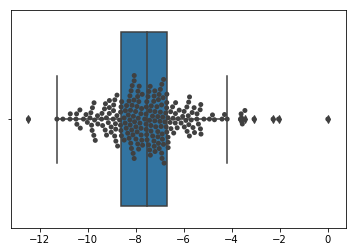

In [189]:
import seaborn as sns
data = np.log(summary_tweets['norm'].tolist())
sns.boxplot(data)
sns.swarmplot(data,color=".25")


In [7]:
# Loading the Number of tweets of Charlie-Hebod per country
summary_tweets = pickle.load(open(os.path.join(Data_path,'Charlie-Hebdo','Geocoded/summary.pickle'), 'rb'))

# Loading the country information to create an iso to country dict
country_data = pickle.load(open('./country_data.pickle','rb'))
iso2Country = dict(zip(country_data['ISO2'].tolist(),country_data.index.tolist()))

summary_tweets = pd.merge(summary_tweets,country_data,left_index=True, right_on='ISO2').reset_index().set_index('ISO2')

summary_tweets = summary_tweets[[('Internet users',''),'text']].dropna()
# Normalizing tweets by internet users : 
summary_tweets['norm'] = summary_tweets['text'] / summary_tweets[('Internet users','')]

/Users/adrian/anaconda3/envs/ada/lib/python3.6/site-packages/pandas/core/reshape/merge.py:551: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [3]:
summary_tweets = pickle.load(open(os.path.join(Data_path,'Charlie-Hebdo','Geocoded/summary.pickle'), 'rb'))

# Loading the country information to create an iso to country dict
country_data = pickle.load(open('./country_data.pickle','rb'))
iso2Country = dict(zip(country_data['ISO2'].tolist(),country_data.index.tolist()))

summary_tweets = pd.merge(summary_tweets,country_data,left_index=True, right_on='ISO2').reset_index().set_index('ISO2')
summary_tweets.replace(0,np.nan,inplace=True)
summary_tweets = summary_tweets[[('Internet users',''),'text']].dropna()
# Normalizing tweets by internet users :
summary_tweets['text'] = np.log(summary_tweets['text'] / summary_tweets[('Internet users','')])

/Users/adrian/anaconda3/envs/ada/lib/python3.6/site-packages/pandas/core/reshape/merge.py:551: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [12]:
summary_tweets['text'].min()

-12.467514162761283

In [18]:
country_data.loc[country_data[('Internet users','')] <= 1000]

area ISO2 ISO3                     languages borders  \
                                                                          
name                                                                      
Christmas Island  135.0   CX  CXR                     [English]      []   
Norfolk Island     36.0   NF  NFK             [English, Norfuk]      []   
Pitcairn Islands   47.0   PN  PCN                     [English]      []   
Tokelau            12.0   TK  TKL  [English, Samoan, Tokelauan]      []   

                                  latlng   language_codes Internet users  \
                                                                           
name                                                                       
Christmas Island   [-10.5, 105.66666666]            [eng]          790.0   
Norfolk Island    [-29.03333333, 167.95]       [eng, pih]          765.0   
Pitcairn Islands  [-25.06666666, -130.1]            [eng]           54.0   
Tokelau                       [-9, -172]  [eng, smo, tkl]          805.0   

                     POP gdp     ...      religion                        \
                                 ...       ortodox buddhism hindu jewish   
name                             ...                                       
Christmas Island  2205.0 NaN     ...           0.0    0.169   0.0    0.0   
Norfolk Island    2210.0 NaN     ...           0.0    0.000   0.0    0.0   
Pitcairn Islands    54.0 NaN     ...           0.0    0.000   0.0    0.0   
Tokelau           1337.0 NaN     ...           0.0    0.000   0.0    0.0   

                                                                     
                 muslim oriental other animist atheist unaffiliated  
name                                                                 
Christmas Island  0.148      0.0   0.0     0.0     0.0          0.0  
Norfolk Island    0.000      0.0   0.0     0.0     0.0          0.0  
Pitcairn Islands  0.000      0.0   0.0     0.0     0.0          0.0  
Tokelau           0.000      0.0   0.0     0.0     0.0          0.0  

[4 rows x 28 columns]

In [20]:
country_data.loc[country_data[('Internet users','')] /country_data[('POP','')]  > 0.9]

area ISO2 ISO3  \
                                        
name                                    
Andorra              468.00   AD  AND   
Bahrain              765.00   BH  BHR   
Bermuda               54.00   BM  BMU   
Denmark            43094.00   DK  DNK   
Finland           338424.00   FI  FIN   
Falkland Islands   12173.00   FK  FLK   
Faroe Islands       1393.00   FO  FRO   
United Kingdom    242900.00   GB  GBR   
Iceland           103000.00   IS  ISL   
Japan             377930.00   JP  JPN   
Liechtenstein        160.00   LI  LIE   
Sri Lanka          65610.00   LK  LKA   
Luxembourg          2586.00   LU  LUX   
Monaco                 2.02   MC  MCO   
Niue                 260.00   NU  NIU   
Netherlands        41850.00   NL  NLD   
Norway            323802.00   NO  NOR   
Pitcairn Islands      47.00   PN  PCN   
Qatar              11586.00   QA  QAT   

                                                    languages  \
                                                                
name                                                            
Andorra                                             [Catalan]   
Bahrain                                              [Arabic]   
Bermuda                                             [English]   
Denmark                                              [Danish]   
Finland                                    [Finnish, Swedish]   
Falkland Islands                                    [English]   
Faroe Islands                               [Danish, Faroese]   
United Kingdom                                      [English]   
Iceland                                           [Icelandic]   
Japan                                              [Japanese]   
Liechtenstein                                        [German]   
Sri Lanka                                    [Sinhala, Tamil]   
Luxembourg                    [German, French, Luxembourgish]   
Monaco                                               [French]   
Niue                                        [English, Niuean]   
Netherlands                                           [Dutch]   
Norway            [Norwegian Nynorsk, Norwegian Bokmål, Sami]   
Pitcairn Islands                                    [English]   
Qatar                                                [Arabic]   

                          borders                         latlng  \
                                                                   
name                                                               
Andorra                [FRA, ESP]                    [42.5, 1.5]   
Bahrain                        []                    [26, 50.55]   
Bermuda                        []          [32.33333333, -64.75]   
Denmark                     [DEU]                       [56, 10]   
Finland           [NOR, SWE, RUS]                       [64, 26]   
Falkland Islands               []                  [-51.75, -59]   
Faroe Islands                  []                       [62, -7]   
United Kingdom              [IRL]                       [54, -2]   
Iceland                        []                      [65, -18]   
Japan                          []                      [36, 138]   
Liechtenstein          [AUT, CHE]      [47.26666666, 9.53333333]   
Sri Lanka                   [IND]                        [7, 81]   
Luxembourg        [BEL, FRA, DEU]            [49.75, 6.16666666]   
Monaco                      [FRA]             [43.73333333, 7.4]   
Niue                           []  [-19.03333333, -169.86666666]   
Netherlands            [BEL, DEU]                   [52.5, 5.75]   
Norway            [FIN, SWE, RUS]                       [62, 10]   
Pitcairn Islands               []         [-25.06666666, -130.1]   
Qatar                       [SAU]                  [25.5, 51.25]   

                   language_codes Internet users           POP           gdp  \
                                                                               
name                            

In [33]:
small_country = list(summary_tweets.loc[summary_tweets[('Internet users','')] <= 10000].index)
country_data.reset_index().set_index('ISO2').loc[small_country]

name     area ISO3                      languages  \
                                                                               
ISO2                                                                           
CK                 Cook Islands    236.0  COK  [English, Cook Islands Māori]   
CX             Christmas Island    135.0  CXR                      [English]   
FK             Falkland Islands  12173.0  FLK                      [English]   
MF                 Saint Martin     53.0  MAF                       [French]   
MS                   Montserrat    102.0  MSR                      [English]   
NF               Norfolk Island     36.0  NFK              [English, Norfuk]   
NR                        Nauru     21.0  NRU               [English, Nauru]   
NU                         Niue    260.0  NIU              [English, Niuean]   
PM    Saint Pierre and Miquelon    242.0  SPM                       [French]   
PN             Pitcairn Islands     47.0  PCN                      [English]   
PW                        Palau    459.0  PLW             [English, Palauan]   
TV                       Tuvalu     26.0  TUV            [English, Tuvaluan]   
WF            Wallis and Futuna    142.0  WLF                       [French]   

     borders                         latlng language_codes Internet users  \
                                                                            
ISO2                                                                        
CK        []  [-21.23333333, -159.76666666]     [eng, rar]         6000.0   
CX        []          [-10.5, 105.66666666]          [eng]          790.0   
FK        []                  [-51.75, -59]          [eng]         3000.0   
MF     [SXM]          [18.08333333, -63.95]          [fra]         1100.0   
MS        []                 [16.75, -62.2]          [eng]         2860.0   
NF        []         [-29.03333333, 167.95]     [eng, pih]          765.0   
NR        []    [-0.53333333, 166.91666666]     [eng, nau]         5100.0   
NU        []  [-19.03333333, -169.86666666]     [eng, niu]         1090.0   
PM        []    [46.83333333, -56.33333333]          [fra]         4500.0   
PN        []         [-25.06666666, -130.1]          [eng]           54.0   
PW        []                   [7.5, 134.5]     [eng, pau]         7650.0   
TV        []                      [-8, 178]     [eng, tvl]         5000.0   
WF        []                [-13.3, -176.2]          [fra]         3450.0   

          POP          gdp     ...      religion                               \
                               ...       ortodox buddhism hindu jewish muslim   
ISO2                           ...                                              
CK     9556.0  244100000.0     ...           0.0    0.000   0.0    0.0  0.000   
CX     2205.0          NaN     ...           0.0    0.169   0.0    0.0  0.148   
FK     2931.0  164500000.0     ...           0.0    0.000   0.0    0.0  0.000   
MF    31949.0  561500000.0     ...           0.0    0.000   0.0    0.0  0.000   
MS     5267.0          NaN     ...           0.0    0.000   0.0    0.0  0.000   
NF     2210.0          NaN     ...           0.0    0.000   0.0    0.0  0.000   
NR     9591.0  150800000.0     ...           0.0    0.000   0.0    0.0  0.000   
NU     1190.0   10010000.0     ...           0.0    0.000   0.0    0.0  0.000   
PM     5595.0  215300000.0     ...           0.0    0.000   0.0    0.0  0.000   
PN       54.0          NaN     ...           0.0    0.000   0.0    0.0  0.000   
PW    21347.0  296000000.0     ...           0.0    0.000   0.0    0.0  0.000   
TV    10959.0   32000000.0     ...           0.0    0.000   0.0    0.0  0.000   
WF    15664.0          NaN     ...           0.0    0.000   0.0    0.0  0.000   

                                                  
     oriental other animist atheist unaffiliated  
ISO2                                              
CK        0.0   0.0     0.0     0.0          0.0  
CX        0.

In [34]:
summary_tweets

,"(Internet users, )",text
ISO2,,
AD,83000.0,-5.448860
AE,5274000.0,-7.244797
AF,2690000.0,-8.173050
AG,60000.0,-5.854605
AI,12000.0,-6.348139
AL,1916000.0,-6.698910
AM,1780000.0,-6.870265
AO,2434000.0,-9.416780
AR,30142000.0,-7.819808


In [ ]:
a = list(summary_tweets['text'].quantile([0,0.25,0.5,0.75,1]))